# Hiperparametrització mamografies completes

### Input: arrays de numpy, disponibles a https://zenodo.org/records/11528223

### Output: - (obtenim millors paràmetres)

**En aquest apartat farem una hiperparametrització amb keras-tuner dels models Efficientnentb2, VGG19 i InceptionV3**



In [1]:
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, AveragePooling2D,
    MaxPooling2D, UpSampling2D, Rescaling, Resizing,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast, Lambda, Activation)
from keras.callbacks import (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
from keras.optimizers import (Adam, RMSprop)
from keras import Sequential, Model
from PIL import Image
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import random
import seaborn as sns

In [2]:
'''!sudo echo -ne '\n' | sudo add-apt-repository ppa:alessandro-strada/ppa >/dev/null 2>&1 # note: >/dev/null 2>&1 is used to supress printing
!sudo apt update >/dev/null 2>&1
!sudo apt install google-drive-ocamlfuse >/dev/null 2>&1
!google-drive-ocamlfuse
!sudo apt-get install w3m >/dev/null 2>&1 # to act as web browser
!xdg-settings set default-web-browser w3m.desktop >/dev/null 2>&1 # to set default browser
%cd /content
!mkdir gdrive
%cd gdrive
!mkdir "My Drive"
!google-drive-ocamlfuse "/content/gdrive/My Drive"
'''


'!sudo echo -ne \'\n\' | sudo add-apt-repository ppa:alessandro-strada/ppa >/dev/null 2>&1 # note: >/dev/null 2>&1 is used to supress printing\n!sudo apt update >/dev/null 2>&1\n!sudo apt install google-drive-ocamlfuse >/dev/null 2>&1\n!google-drive-ocamlfuse\n!sudo apt-get install w3m >/dev/null 2>&1 # to act as web browser\n!xdg-settings set default-web-browser w3m.desktop >/dev/null 2>&1 # to set default browser\n%cd /content\n!mkdir gdrive\n%cd gdrive\n!mkdir "My Drive"\n!google-drive-ocamlfuse "/content/gdrive/My Drive"\n'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

zip_file_path = '/content/drive/MyDrive/3-class.zip'

# Ruta de extracción
extract_path = '/content/'

# Descomprimir el archivo zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Arxiu descomprimit a:", extract_path)

Arxiu descomprimit a: /content/


In [5]:
# Importem Tensorflow
import tensorflow as tf
print("TF version   : ", tf.__version__)

# Necessitarem GPU
print("GPU available: ", tf.config.list_physical_devices('GPU'))

#Keras version is 3.0.5
import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.15.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras version   :  2.15.0


### Creem conjunt de dades anotades de mamografies amb contrast


In [6]:
test_images = np.load('/content/test_images.npy')
test_labels = np.load('/content/test_labels.npy')
val_images = np.load('/content/val_images.npy')
val_labels = np.load('/content/val_labels.npy')
train_images = np.load('/content/train_images.npy')
train_labels = np.load('/content/train_labels.npy')

In [7]:
train_images.shape

(4456, 224, 224, 3)

## Comprovem que l'importació s'hagi realitzat correctament

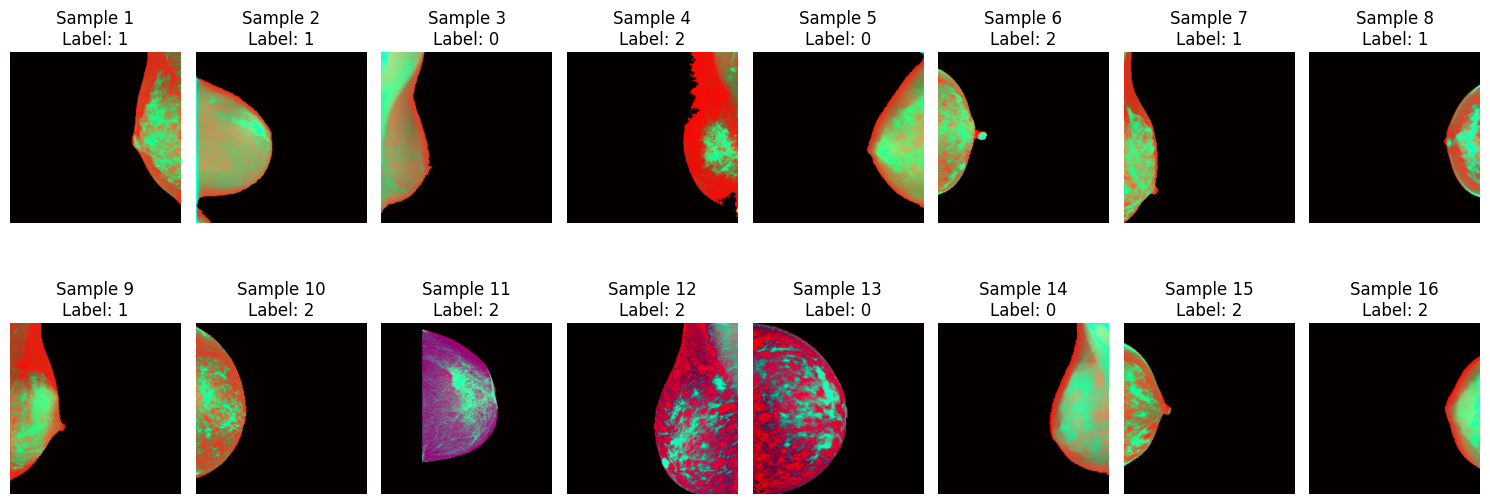

In [8]:
def check_import(test_images, test_labels, num_ex):
    """
    Mostra una selecció d'imatges amb les seves etiquetes corresponents per comprovar el preprocessat.

    Args:
    - test_images (array): Array que conté les imatges a visualitzar.
    - test_labels (array): Array que conté les etiquetes corresponents a les imatges.
    - num_ex (int): Nombre d'imatges a visualitzar.

    Returns:
    - No retorna cap valor, només mostra les imatges i les seves etiquetes associades.
    """

    num_rows = (num_ex + 7) // 8
    fig, axes = plt.subplots(num_rows, 8, figsize=(15, num_rows * 3))

    for i in range(num_ex):
        row = i // 8
        col = i % 8
        axes[row, col].imshow(test_images[i])
        axes[row, col].set_title(f"Sample {i+1}\nLabel: {test_labels[i]}")
        axes[row, col].axis('off')

    for i in range(num_ex, num_rows * 8):
        row = i // 8
        col = i % 8
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

check_import(test_images, test_labels, 16)

### UTILS


In [9]:
def plot_metrics(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model(model, test_ds):
    """
    Avalua un model utilitzant un conjunt de dades de prova i retorna les prediccions i les imatges.

    Args:
    - model: Model a avaluar.
    - test_ds: Conjunt de dades de prova.

    Returns:
    - y_true: Etiquetes reals del conjunt de dades de prova.
    - y_pred: Prediccions del model.
    - imatges_array: Array que conté les imatges utilitzades per a la predicció.
    """
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        y_true.extend(labels.numpy())
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    return y_true, y_pred


def plot_sample_images(train_ds, num_samples=9):
    """
    Mostra una mostra d'imatges amb les seves etiquetes corresponents.

    Args:
    - train_ds (tf.data.Dataset): Dataset d'entrenament que conté les imatges i les seves etiquetes.
    - num_samples (int): Nombre d'imatges a mostrar.

    Returns:
    - No retorna cap valor, només mostra les imatges i les seves etiquetes associades.
    """
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(min(num_samples, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(str(labels[i].numpy()))
            plt.axis("off")
            height, width, channels = images[i].shape
            pixel_range = (np.min(images[i]), np.max(images[i]))


def replicate_augmented_images(train_ds, model_augmentation, num_replications=4):
    """
    Reprodueix una imatge aleatòria del conjunt de dades d'entrenament múltiples vegades amb augmentació.

    Args:
    - train_ds (tf.data.Dataset): Dataset d'entrenament que conté les imatges.
    - model_augmentation (tf.keras.Sequential): Model d'augmentació que s'aplicarà a la imatge.
    - num_replications (int): Nombre de vegades que es vol replicar la imatge amb augmentació.

    Returns:
    - No retorna cap valor, només mostra les imatges amb augmentació.
    """
    for images, _ in train_ds.take(1):
        sample_image = images[0]

    augmented_images = [model_augmentation(tf.expand_dims(sample_image, 0)) for _ in range(num_replications)]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, num_replications + 1, 1)
    plt.title('Imatge original')
    plt.imshow(sample_image.numpy().astype("uint8"))
    plt.axis("off")

    for i, augmented_image in enumerate(augmented_images):
        plt.subplot(1, num_replications + 1, i + 2)
        plt.title(f'Imatge amb augmentació {i+1}')
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")

    plt.show()


## Creem els tensors de tensorflow a partir dels arrays

In [10]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

## Comprovem algunes imatges del tensor d'entrenament amb les seves etiquetes

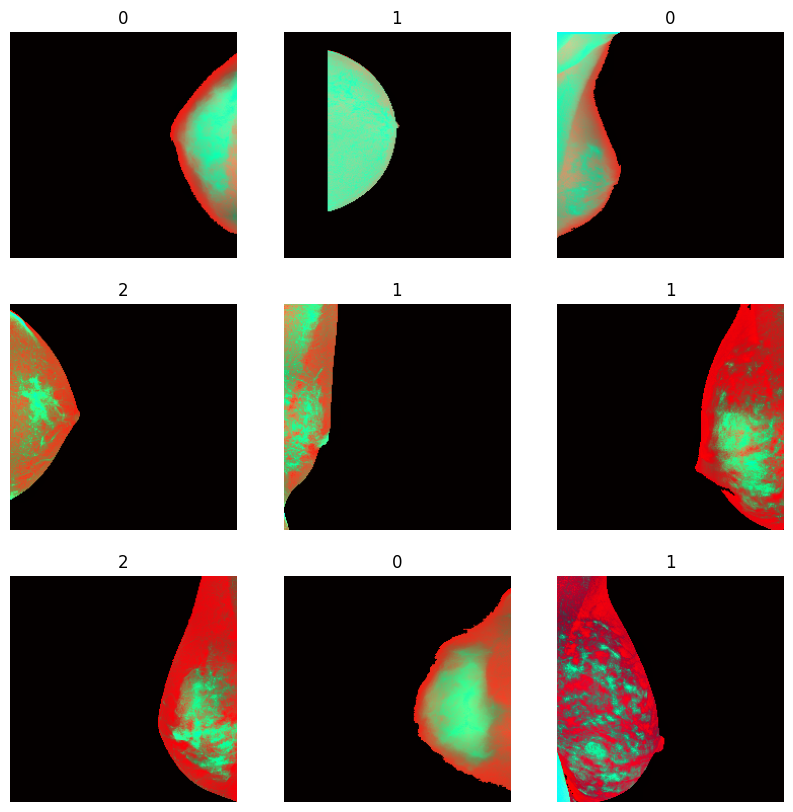

In [11]:
plot_sample_images(train_ds, num_samples=9)

## Augment de dades
Tot i que després ho utilitzarem dins del ModelGenerator, comprovem quines modificacions d'augmentació són acceptables

In [12]:
model_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomFlip("vertical"),
    #RandomRotation(0.1),
    #RandomZoom(0.1),
    RandomContrast(0.1)
])

# Custom Model

**En aquest primer punt crearem una classe per construir i evaluar els models creats. Crearem una estructura simple amb una primera capa de Flatten/ Globalaveragepooling2D, seguida de x capes ocultes i una capa de dropout per cada una. Per acabar, una capa de sortida amb 3 neurones**

In [11]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception_v3
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_input_vgg19
from tensorflow.keras.applications.imagenet_utils import preprocess_input as preprocess_input_default

class CustomModel:
    def __init__(self, input_shape = (224,224,3), train_data = train_ds, val_data = val_ds, test_data = test_ds, pretrained_model=None, hidden_layers=None, dropout=None, pooling='flatten', weights='imagenet', num_outputs=3, trainable=False, trainable_layers=None, model_augmentation=True):
        """
        Inicialitza una instància de la classe CustomModel per generar un model de xarxa neuronal convolucional (CNN) amb opcions per pre-entrenar i personalitzar les capes ocultes.

        Args:
        - input_shape (tuple): Dimensions de la imatge d'entrada (ex: (224, 224, 3)).
        - pretrained_model (str or None): Model pre-entrenat a utilitzar (opcions: 'inception', 'efficientnetb2', 'vgg19' o None per cap capa pre-entrenada).
        - hidden_layers (list or None): Llista de dimensions per les capes ocultes (ex: [126, 64, 32]) o None per cap capa oculta.
        - dropout (list or None): Llista de valors de dropout per a cada capa oculta o None per cap dropout.
        - pooling (str): Tipus de capa de pooling ('flatten' o 'globalaverage').
        - weights (str): Pesos inicials del model ('imagenet' o None).
        - num_outputs (int): Nombre de neurones a la capa de sortida.
        - trainable (bool): Indica si es permet re-entrenar les capes (True) o no (False).
        - trainable_layers (list or None): Llista de noms de les capes a re-entrenar o None per re-entrenar totes les capes.
        - model_augmentation (bool): Indica si es vol utilitzar data augmentació (True) o no (False).
        """
        self.input_shape = input_shape
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.pretrained_model = pretrained_model
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        self.pooling = pooling
        self.weights = weights
        self.num_outputs = num_outputs
        self.trainable = trainable
        self.trainable_layers = trainable_layers
        self.model_augmentation = model_augmentation

        self.pretrained_model_options = {
            'inception': tf.keras.applications.InceptionV3,
            'efficientnetb2': tf.keras.applications.EfficientNetB2,
            'vgg19': tf.keras.applications.VGG19,
            'none': None
        }

        self.pooling_options = {
            'flatten': Flatten,
            'globalaverage': GlobalAveragePooling2D
        }

    def generate_model(cls):
      # Selecció del model pre-entrenat
      base_model_class = cls.pretrained_model_options.get(cls.pretrained_model)
      base_model = None
      preprocess_input = preprocess_input_default

      if base_model_class:
          base_model = base_model_class(input_shape=cls.input_shape, include_top=False, weights=cls.weights)
          for layer in base_model.layers:
              layer.trainable = False
          if cls.pretrained_model == 'inception':
              preprocess_input = tf.keras.applications.inception_v3.preprocess_input
          elif cls.pretrained_model == 'efficientnetb2':
              preprocess_input = tf.keras.applications.efficientnet.preprocess_input
          elif cls.pretrained_model == 'vgg19':
              preprocess_input = tf.keras.applications.vgg19.preprocess_input

      # Construcció del model base
      scratch_model = [Conv2D(16, (3, 3), activation='relu', input_shape=cls.input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),]

      # Selecció de la capa de pooling
      pool_layer_class = cls.pooling_options.get(cls.pooling)
      pool_layer = None
      if pool_layer_class:
          pool_layer = pool_layer_class()

      # Construcció de les capes ocultes
      hidden_layers_list = []
      if cls.hidden_layers:
          hidden_layers_list.append(pool_layer)
          for units, drop_rate in zip(cls.hidden_layers, cls.dropout):
              hidden_layers_list.append(Dense(units, activation='relu'))
              if drop_rate:
                  hidden_layers_list.append(Dropout(drop_rate))
      else:
          hidden_layers_list = [pool_layer]

      # Construcció del model complet
      if base_model:
          if cls.model_augmentation:
              model_augmentation = tf.keras.Sequential([
                  RandomFlip("horizontal"),
                  RandomFlip("vertical"),
                  RandomContrast(0.1)
              ])
              model = Sequential([model_augmentation] + [Lambda(preprocess_input)] + [base_model] + hidden_layers_list + [Dense(cls.num_outputs, activation='softmax')])
          else:
              model = Sequential([Lambda(preprocess_input)] + [base_model] + hidden_layers_list + [Dense(cls.num_outputs, activation='softmax')])
      else:
          if cls.model_augmentation:
              model_augmentation = tf.keras.Sequential([
                  RandomFlip("horizontal"),
                  RandomFlip("vertical"),
                  RandomContrast(0.1)
              ])
              model = Sequential([model_augmentation] + [Lambda(preprocess_input)] + scratch_model +  hidden_layers_list + [Dense(cls.num_outputs, activation='softmax')])
          else:
              model = Sequential([Lambda(preprocess_input)] + scratch_model + hidden_layers_list + [Dense(cls.num_outputs, activation='softmax')])

      model.build((None, *cls.input_shape))

      return model

    def show_layers(self, model):
        for i, layer in enumerate(model.layers):
            print(f"Layer {i}: {layer.name} - Trainable: {layer.trainable}")


    def train(self, model, optimizer = Adam(learning_rate=1e-3), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], epochs = 50, callbacks=None):
        """

        Args:
          model:
          optimizer:
          loss:
          metrics:
          epochs:
          callbacks:

        Returns:

        """
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        history = model.fit(self.train_data, epochs=epochs, validation_data=self.val_data, callbacks=callbacks)
        return history

    def full_report(self, model, history):

        plot_metrics(history)

        y_true, y_pred = evaluate_model(model, self.test_data)

        plot_confusion_matrix(y_true, y_pred, ('Normal', 'Benign', 'Malignant'))

        print(classification_report(y_true, y_pred))

        loss, accuracy = model.evaluate(self.test_data)

        print(f'Pèrdua en el conjunt de dades de test: {loss}')
        print(f'Precisió en el conjunt de dades de test: {accuracy}')

    def freeze_layers(self, model_initial, num_layers_to_freeze):
        for layer in model_initial.layers[2].layers[:num_layers_to_freeze]:
            layer.trainable = False
        for layer in model_initial.layers[2].layers[num_layers_to_freeze:]:
            layer.trainable = True
        return model_initial



In [12]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


# Busquem millors paràmetres

In [13]:
from kerastuner.tuners import BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters

<ipython-input-13-a572aee69c8e>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


## Model inception

In [17]:
def build_model(hp):
    hp_pretrained_model = hp.Choice('pretrained_model', ['inception'])
    hp_num_fc_layers = hp.Int('num_fc_layers', min_value=0, max_value=3, step=1)
    hp_fc_neurons = [hp.Int(f'fc_neurons_{i}', min_value=16, max_value=248, step=128) for i in range(hp_num_fc_layers)]
    hp_num_dropout_layers = hp.Int('num_dropout_layers', min_value=0, max_value=3, step=1)
    hp_dropout_rates = [hp.Float(f'dropout_rate_{i}', min_value=0.0, max_value=0.5, step=0.1) for i in range(hp_num_dropout_layers)]
    hp_pooling = hp.Choice('pooling', ['flatten', 'globalaverage'])

    custom_model = CustomModel(
        pretrained_model=hp_pretrained_model,
        hidden_layers=hp_fc_neurons,
        dropout=hp_dropout_rates,
        pooling=hp_pooling
    )
    model = custom_model.generate_model()


    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    directory='keras_tuner',
    project_name='custom_model'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=6, factor=0.2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(train_ds, validation_data=val_ds, epochs=30, callbacks =[reduce_lr, early_stopping])

best_model = tuner.get_best_models(num_models=1)[0]


Trial 30 Complete [00h 06m 16s]
val_accuracy: 0.4492146670818329

Best val_accuracy So Far: 0.5738219618797302
Total elapsed time: 02h 42m 44s


In [18]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_params = best_hyperparameters.values
print(best_params)

{'pretrained_model': 'inception', 'num_fc_layers': 1, 'num_dropout_layers': 3, 'pooling': 'globalaverage', 'fc_neurons_0': 144, 'fc_neurons_1': 16, 'dropout_rate_0': 0.2, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.1, 'fc_neurons_2': 16}


## Model VGG19

In [14]:
def build_model(hp):
    hp_pretrained_model = hp.Choice('pretrained_model', ['vgg19'])
    hp_num_fc_layers = hp.Int('num_fc_layers', min_value=0, max_value=3, step=1)
    hp_fc_neurons = [hp.Int(f'fc_neurons_{i}', min_value=16, max_value=2048, step=128) for i in range(hp_num_fc_layers)]
    hp_num_dropout_layers = hp.Int('num_dropout_layers', min_value=0, max_value=3, step=1)
    hp_dropout_rates = [hp.Float(f'dropout_rate_{i}', min_value=0.0, max_value=0.5, step=0.1) for i in range(hp_num_dropout_layers)]
    hp_pooling = hp.Choice('pooling', ['flatten', 'globalaverage'])

    custom_model = CustomModel(
        pretrained_model=hp_pretrained_model,
        hidden_layers=hp_fc_neurons,
        dropout=hp_dropout_rates,
        pooling=hp_pooling
    )
    model = custom_model.generate_model()


    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

tuner2 = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    directory='keras_tuner2',
    project_name='custom_model2'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=6, factor=0.2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner2.search(train_ds, validation_data=val_ds, epochs=30, callbacks =[reduce_lr, early_stopping])

best_model2 = tuner2.get_best_models(num_models=1)[0]

Trial 30 Complete [00h 10m 50s]
val_accuracy: 0.6136125922203064

Best val_accuracy So Far: 0.6293193697929382
Total elapsed time: 05h 10m 33s


In [16]:
best_hyperparameters2 = tuner2.get_best_hyperparameters(num_trials=1)[0]
best_params2 = best_hyperparameters2.values
print(best_params2)

{'pretrained_model': 'vgg19', 'num_fc_layers': 1, 'num_dropout_layers': 1, 'pooling': 'flatten', 'fc_neurons_0': 1680, 'fc_neurons_1': 1424, 'dropout_rate_0': 0.2, 'dropout_rate_1': 0.4}


## Model Efficientnet_b2

In [15]:
def build_model(hp):
    hp_pretrained_model = hp.Choice('pretrained_model', ['efficientnetb2'])
    hp_num_fc_layers = hp.Int('num_fc_layers', min_value=0, max_value=3, step=1)
    hp_fc_neurons = [hp.Int(f'fc_neurons_{i}', min_value=16, max_value=2048, step=128) for i in range(hp_num_fc_layers)]
    hp_num_dropout_layers = hp.Int('num_dropout_layers', min_value=0, max_value=3, step=1)
    hp_dropout_rates = [hp.Float(f'dropout_rate_{i}', min_value=0.0, max_value=0.5, step=0.1) for i in range(hp_num_dropout_layers)]
    hp_pooling = hp.Choice('pooling', ['flatten', 'globalaverage'])

    custom_model = CustomModel(
        pretrained_model=hp_pretrained_model,
        hidden_layers=hp_fc_neurons,
        dropout=hp_dropout_rates,
        pooling=hp_pooling
    )
    model = custom_model.generate_model()


    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

tuner3 = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    directory='keras_tuner4',
    project_name='custom_model4'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=6, factor=0.2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner3.search(train_ds, validation_data=val_ds, epochs=30, callbacks =[reduce_lr, early_stopping])

best_model3 = tuner3.get_best_models(num_models=1)[0]

31790344/31790344 [==============================] - 2s 0us/step

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
efficientnetb2    |efficientnetb2    |pretrained_model
1                 |1                 |num_fc_layers
2                 |2                 |num_dropout_layers
globalaverage     |globalaverage     |pooling

Epoch 1/30
140/140 [==============================] - 29s 144ms/step - loss: 0.9462 - accuracy: 0.5209 - val_loss: 0.8567 - val_accuracy: 0.5812 - lr: 0.0010
Epoch 2/30
139/140 [============================>.] - ETA: 0s - loss: 0.8632 - accuracy: 0.5769

KeyboardInterrupt: 

In [32]:
best_hyperparameters3 = tuner3.get_best_hyperparameters(num_trials=1)[0]
best_params3 = best_hyperparameters3.values
print(best_params3)

{'pretrained_model': 'efficientnetb2', 'num_fc_layers': 1, 'num_dropout_layers': 3, 'pooling': 'flatten', 'fc_neurons_0': 1040, 'dropout_rate_0': 0.2, 'fc_neurons_1': 1040, 'fc_neurons_2': 1168, 'dropout_rate_1': 0.30000000000000004, 'dropout_rate_2': 0.0}
